In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gzip
from unidip import UniDip
from scipy.cluster import hierarchy
from scipy.spatial import distance
import os.path
from os import path
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats.distributions import chi2
from collections import Counter

From here, we work on the filtered SNP dataset (so far indels have been left out) at `/scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz`

For these analyses, we remove the two White-Face phenotypes from Marion (I suspect one is a genuine Schlegel, and not the other) - one goal will be to assess whether they are migrants or convergent mutants.

## Genome-wide Fst distribution

In [2]:
%%bash
cat ../MacaroniGenomesPop.csv | grep e_chrysolophus | cut -f 4 -d ',' > /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys
cat ../MacaroniGenomesPop.csv | grep e_schlegeli | cut -f 4 -d ',' > /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eschle

module load vcftools
vcftools --gzvcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--weir-fst-pop /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys \
--weir-fst-pop /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eschle \
--out /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys-eschle

vcftools  0.1.16  environment loaded 

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz
	--weir-fst-pop /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys
	--weir-fst-pop /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eschle
	--keep /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys
	--keep /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eschle
	--out /users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys-eschle

Using zlib version: 1.2.7
Keeping individuals in 'keep' list
After filtering, kept 46 out of 48 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: 0.0028817
Weir and Cockerham weighted Fst estimate: 0.0097521
After filtering, kept 883354 out of a possible 883354 Sites
Run Time = 13.00 seconds


In [53]:
fst = pd.read_csv("/users/cristofa/scratch/Penguins/Macaroni/vcfstats/echrys-eschle.weir.fst", sep="\t")

In [54]:
# Load the scaffold size dictionary from the VCF file:
scaf, length = [], []
with gzip.open ("/scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz", "rt") as ifile:
    for line in ifile:
        if "##contig=" in line:
            row = line.strip("\n").split("=")
            length.append(int(row[3].strip(">")))
            scaf.append(row[2].split(",")[0])
        elif "#CHROM" in line:
            break
scafDict = dict(zip(scaf, length))

In [110]:
# Sort the dataframe by scaffold length:
fst["LEN"] = [scafDict[s] for s in fst["CHROM"]]
fst = fst.sort_values(['LEN', 'CHROM', 'POS'], ascending=(False, True, True))
fst.reset_index(inplace=True, drop=True)

# Add a FULLPOS column corresponding to position + cumulative sum of sorted scaffold lengths
uniquePairs = [x for x in sorted(set([x for x in zip(fst["CHROM"], fst["LEN"])]), key = lambda t: t[1], reverse = True)]
s = [x[0] for x in uniquePairs]
l = [x[1] for x in uniquePairs]
l = [0] + l[:-1]
csDict=dict(zip(s, np.cumsum(l)))

fst["FULLPOS"] = [csDict[x] + fst["POS"][i] for i, x in enumerate(fst["CHROM"])]

In [115]:
# Draw the boundaries of bands for scaffolds:
stop = []
for i, c in enumerate(fst["CHROM"][:-1]):
    if c != fst["CHROM"][i+1]:
        stop.append(i)
        
start = [x+1 for x in stop[:-1]]
start = [0] + start

# for color bands, we only want every second band:
bands = [x for i, x in enumerate(zip(start, stop)) if (i%2 == 0)]

# Redraw bands by position and not index:
bandsPOS = []
for b in bands:
    b0 = fst["FULLPOS"][b[0]]
    b1 = fst["FULLPOS"][b[1]]
    bandsPOS.append((b0, b1))

In [117]:
# Get scaffold mean:
fst_mean, fst_loc = [], []
for i, s in enumerate(start):
    fst_mean.append(np.mean(fst["WEIR_AND_COCKERHAM_FST"][s:stop[i]]))
    fst_loc.append(np.mean([fst["FULLPOS"][s], fst["FULLPOS"][stop[i]]]))

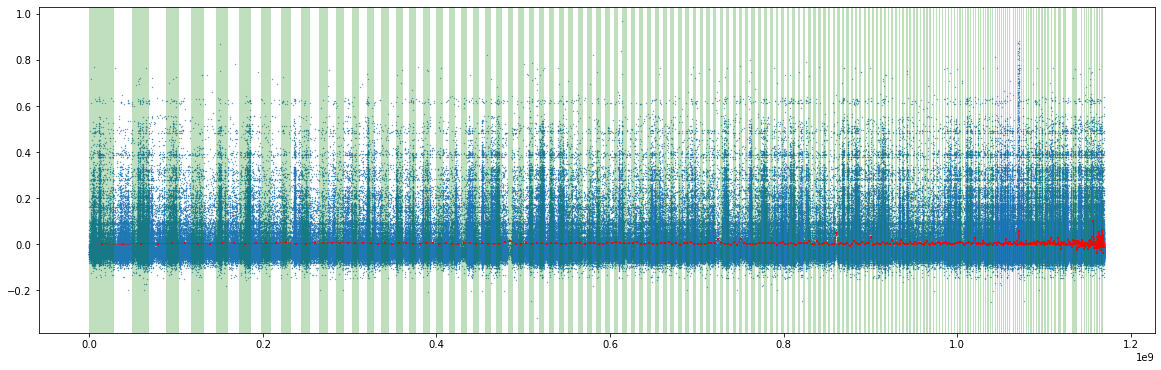

In [118]:
plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(fst["FULLPOS"], fst["WEIR_AND_COCKERHAM_FST"], s=.1)
plt.scatter(fst_loc, fst_mean, c="r", marker="+", s=8)
plt.plot(fst_loc, fst_mean, c="r", lw=.5)
plt.show()

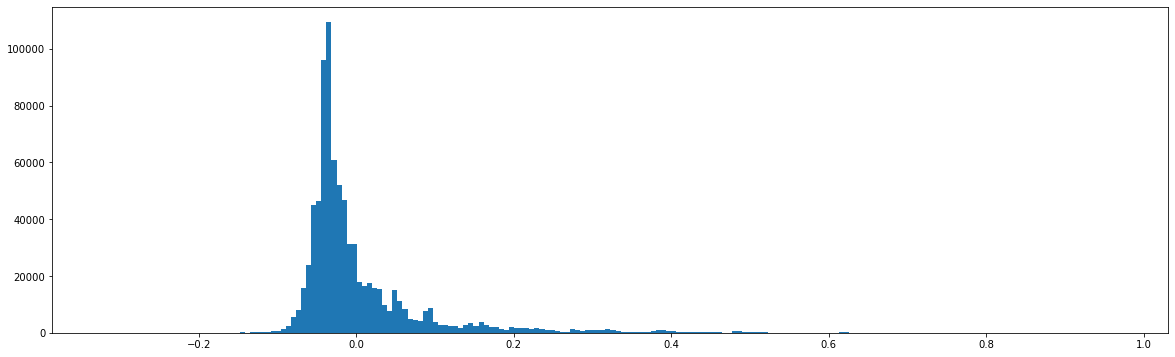

In [14]:
plt.hist(fst["WEIR_AND_COCKERHAM_FST"], bins=200)
plt.show()

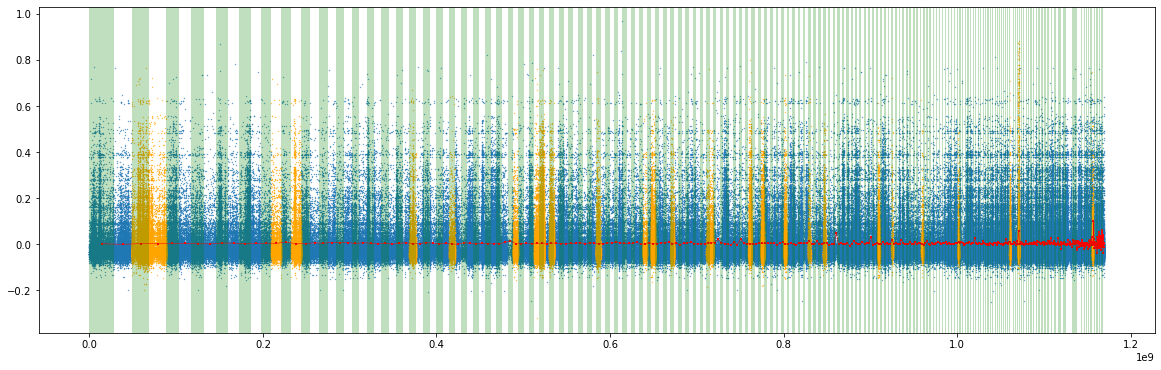

In [119]:
outflank_spe = ["Scaffold132", "Scaffold142", "Scaffold163", "Scaffold17", "Scaffold174", "Scaffold185", "Scaffold19", "Scaffold193", "Scaffold196", "Scaffold209", "Scaffold229", "Scaffold231", "Scaffold245", "Scaffold255", "Scaffold257", "Scaffold262", "Scaffold273", "Scaffold284", "Scaffold287", "Scaffold299", "Scaffold309", "Scaffold467", "Scaffold54", "Scaffold563", "Scaffold57", "Scaffold63", "Scaffold68", "Scaffold7", "Scaffold847"]
#outflank_spe = ["Scaffold56"]

#fst_bulk
fst_outflank = fst.loc[fst["CHROM"].isin(outflank_spe)]
fst_bulk = fst.loc[-fst["CHROM"].isin(outflank_spe)]

plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(fst_bulk["FULLPOS"], fst_bulk["WEIR_AND_COCKERHAM_FST"], s=.1)
plt.scatter(fst_outflank["FULLPOS"], fst_outflank["WEIR_AND_COCKERHAM_FST"], s=.1, c='orange')
plt.scatter(fst_loc, fst_mean, c="r", marker="+", s=8)
plt.plot(fst_loc, fst_mean, c="r", lw=.5)
plt.show()

## Positions flagged in DAPC
Clearly if we oppose the two phenotypes, it's Scaffold 19 that is driving most of the difference (although note - there has been no cross-validation here yet)

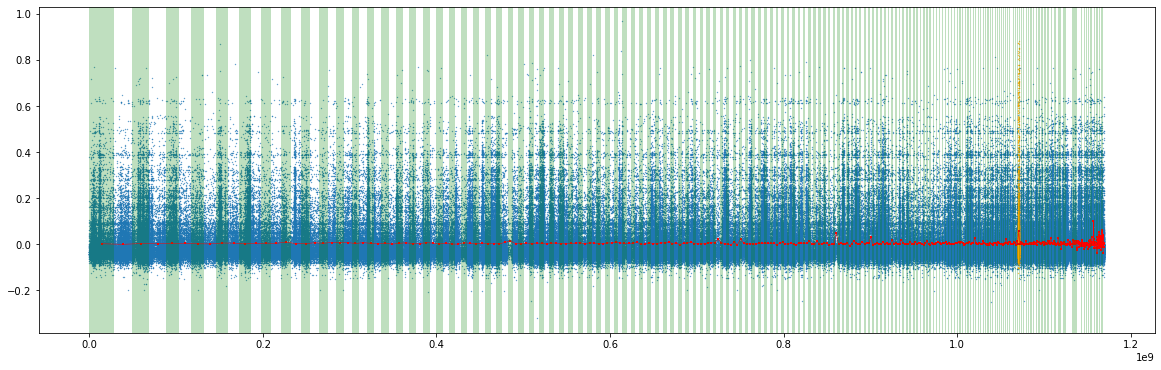

In [120]:
dapc_out = ["Scaffold19"]

fst_outflank = fst.loc[fst["CHROM"].isin(dapc_out)]
fst_bulk = fst.loc[-fst["CHROM"].isin(dapc_out)]

plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(fst_bulk["FULLPOS"], fst_bulk["WEIR_AND_COCKERHAM_FST"], s=.1)
plt.scatter(fst_outflank["FULLPOS"], fst_outflank["WEIR_AND_COCKERHAM_FST"], s=.1, c='orange')
plt.scatter(fst_loc, fst_mean, c="r", marker="+", s=8)
plt.plot(fst_loc, fst_mean, c="r", lw=.5)

plt.savefig('/users/cristofa/scratch/Penguins/Macaroni/jupyter/fst-dapc.png', format='png', dpi=600)  
plt.show()

Check out what actually is in Scaffold 19, before we proceed with more detailed sequence analysis there (not for ex. that we would expect more homozygotes in Schlegel, as a mark of recent selection).

In [121]:
df = pd.DataFrame(columns=('scaffold', 'source', "feature", "start", "end", "score", "strand", "phase", "attributes"))

with gzip.open("/scratch/project_2000913/Penguins/Emperor/ref/Aptenodytes_forsteri.gff.gz", "rt") as ifile:
    i = 0
    for line in ifile:
        row = line.strip("\n").split("\t")
        gffScaf = row[0]
        gffFeat = row[2]
        if gffScaf == "Scaffold19":
            df.loc[i] = row
            i += 1

            
mRNAdf = df.loc[df["feature"] == "mRNA"]
mRNAdf.reset_index(inplace=True, drop=True)
mRNAdf["function"] = [f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in mRNAdf["attributes"]]]
CDSdf = df.loc[df["feature"] == "CDS"]
CDSdf.reset_index(inplace=True, drop=True)

/users/cristofa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [17]:
hits_dapc = pd.read_csv("/scratch/project_2000913/Penguins/Macaroni/dapc/dapc.spe.res", delimiter=" ")

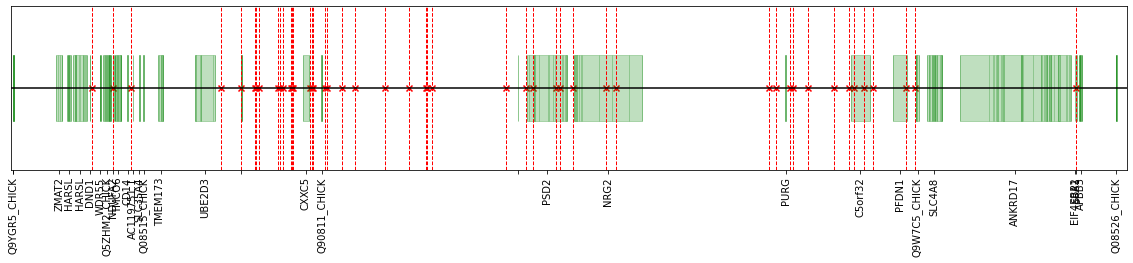

In [24]:
# Plot Scaffold19 with genes on it, and DAPC positions:
plt.rcParams['figure.figsize'] = [20, 3]

geneloc, genename = [], []

# Overall span of the genes:
for i in range(mRNAdf.shape[0]):
    s = int(mRNAdf["start"][i])
    e = int(mRNAdf["end"][i])
    geneloc.append(np.mean([s, e]))
    genename.append(mRNAdf["function"][i])
    plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")
    
# CDS:
for i in range(CDSdf.shape[0]):
    s = int(CDSdf["start"][i])
    e = int(CDSdf["end"][i])
    plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")

scaf19_dapc = hits_dapc.loc[hits_dapc["CHROM"] == "Scaffold19"]
scaf19_dapc.reset_index(inplace=True, drop=True)
for i in range(scaf19_dapc.shape[0]):
    plt.axvline(scaf19_dapc["POS"][i], c="r", lw=1, ls="--")
    plt.scatter(scaf19_dapc["POS"][i], 0, c="r", marker="x")

plt.ylim(-1, 1)
plt.xlim(0, scafDict["Scaffold19"])
plt.axhline(0, c='k')
plt.yticks([])
plt.xticks(geneloc, genename, rotation=90)
plt.show()

In [335]:
genename

['',
 'Q9YGR5_CHICK',
 'ZMAT2',
 'HARSL',
 'HARSL',
 'DND1',
 'WDR55',
 'Q5ZHM2_CHICK',
 'NDUFA2',
 'TMCO6',
 'CD14',
 'AC119751.1',
 'SLC35A4',
 'Q08515_CHICK',
 'TMEM173',
 'UBE2D3',
 '',
 'CXXC5',
 'Q90811_CHICK',
 '',
 'PSD2',
 'NRG2',
 'PURG',
 'C5orf32',
 'PFDN1',
 'Q9W7C5_CHICK',
 'SLC4A8',
 'ANKRD17',
 'EIF4EBP2',
 'SRA1',
 'APBB3',
 'Q08526_CHICK']

## Positions flagged in PCAdapt
With K = 4 axes retained. Here, we removed G12, which drove alone the first axis of variation. Pvalues are Bonferroni-corrected, at a post-correction level of 0.001

['Scaffold110', 'Scaffold119', 'Scaffold13', 'Scaffold132', 'Scaffold133', 'Scaffold14', 'Scaffold142', 'Scaffold15', 'Scaffold181', 'Scaffold19', 'Scaffold2', 'Scaffold207', 'Scaffold208', 'Scaffold217', 'Scaffold241', 'Scaffold243', 'Scaffold259', 'Scaffold26', 'Scaffold268', 'Scaffold284', 'Scaffold299', 'Scaffold321', 'Scaffold366', 'Scaffold373', 'Scaffold4', 'Scaffold428', 'Scaffold441', 'Scaffold444', 'Scaffold54', 'Scaffold65', 'Scaffold657', 'Scaffold68', 'Scaffold79', 'Scaffold81', 'Scaffold83', 'Scaffold86', 'Scaffold87', 'Scaffold887', 'Scaffold9', 'Scaffold93']


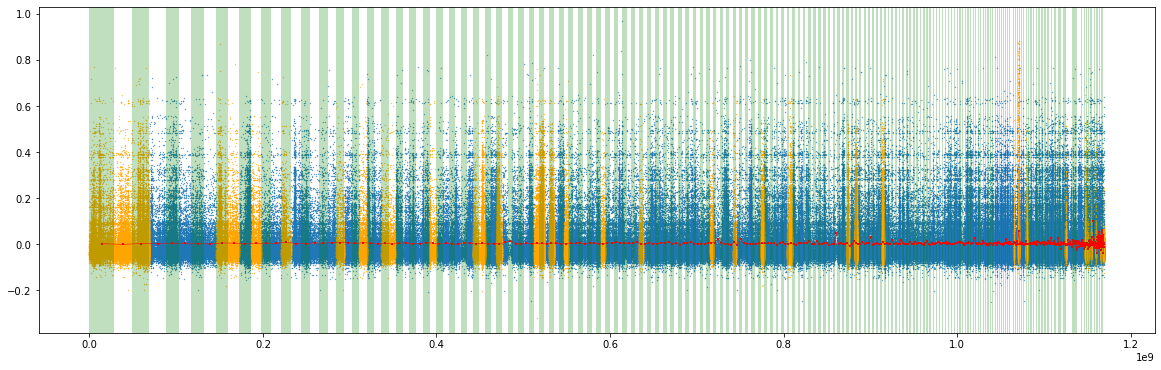

In [301]:
hits_pcadapt = pd.read_csv("/scratch/project_2000913/Penguins/Macaroni/dapc/pcadapt.res", delimiter=" ")
hits_pcadapt.rename(columns={'V2': 'CHROM', 'V4': 'POS'}, inplace=True)

# Keep only scaffolds with more than 5 hits:
c = dict(Counter(hits_pcadapt["CHROM"]))
pcadapt_res = [x for x in c if c[x]>1]
print(sorted(pcadapt_res))

fst_pcadapt = fst.loc[fst["CHROM"].isin(pcadapt_res)]
fst_bulk = fst.loc[-fst["CHROM"].isin(pcadapt_res)]

plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(fst_bulk["FULLPOS"], fst_bulk["WEIR_AND_COCKERHAM_FST"], s=.1)
plt.scatter(fst_pcadapt["FULLPOS"], fst_pcadapt["WEIR_AND_COCKERHAM_FST"], s=.1, c='orange')
plt.scatter(fst_loc, fst_mean, c="r", marker="+", s=8)
plt.plot(fst_loc, fst_mean, c="r", lw=.5)
plt.show()

In [194]:
# A function to plot outlier positions together with gene context:
def plotRegion(hits, scaffold):

    df = pd.DataFrame(columns=('scaffold', 'source', "feature", "start", "end", "score", "strand", "phase", "attributes"))
    with gzip.open("/scratch/project_2000913/Penguins/Emperor/ref/Aptenodytes_forsteri.gff.gz", "rt") as ifile:
        i = 0
        for line in ifile:
            row = line.strip("\n").split("\t")
            gffScaf = row[0]
            gffFeat = row[2]
            if gffScaf == scaffold:
                df.loc[i] = row
                i += 1

    mRNAdf = df.loc[df["feature"] == "mRNA"].copy()
    mRNAdf.reset_index(inplace=True, drop=True)
    fun = [f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in mRNAdf["attributes"]]]
    mRNAdf["function"] = fun

    CDSdf = df.loc[df["feature"] == "CDS"].copy()
    CDSdf.reset_index(inplace=True, drop=True)

    geneloc, genename = [], []

    # Overall span of the genes:
    for i in range(mRNAdf.shape[0]):
        s = int(mRNAdf["start"][i])
        e = int(mRNAdf["end"][i])
        geneloc.append(np.mean([s, e]))
        genename.append(mRNAdf["function"][i])
        plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")

    # CDS:
    for i in range(CDSdf.shape[0]):
        s = int(CDSdf["start"][i])
        e = int(CDSdf["end"][i])
        plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")

    this_scaf_pcadapt = hits_pcadapt.loc[hits_pcadapt["CHROM"] == scaffold]
    this_scaf_pcadapt.reset_index(inplace=True, drop=True)

    ##########
    # Plot:
    plt.rcParams['figure.figsize'] = [20, 3]

    for i in range(this_scaf_pcadapt.shape[0]):
        plt.axvline(this_scaf_pcadapt["POS"][i], c="r", lw=1, ls="--")
        plt.scatter(this_scaf_pcadapt["POS"][i], 0, c="r", marker="x")

    plt.ylim(-1, 1)
    minx, maxx = plt.xlim()
    plt.axhline(0, c='k')
    plt.yticks([])
    plt.xticks(geneloc, genename, rotation=90)
    plt.title(scaffold, loc="left")
    plt.show()

['Scaffold133', 'Scaffold19', 'Scaffold268', 'Scaffold441', 'Scaffold81', 'Scaffold887']


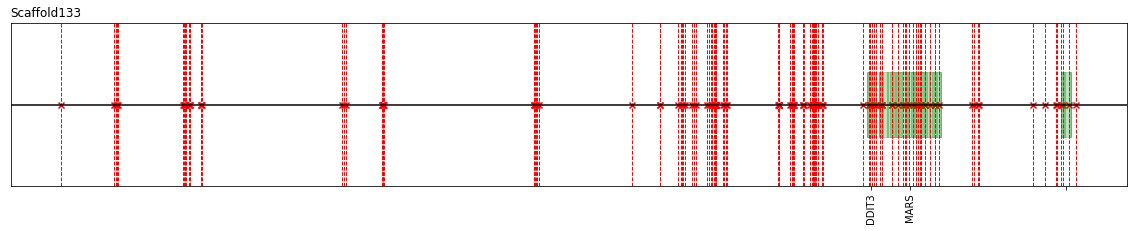

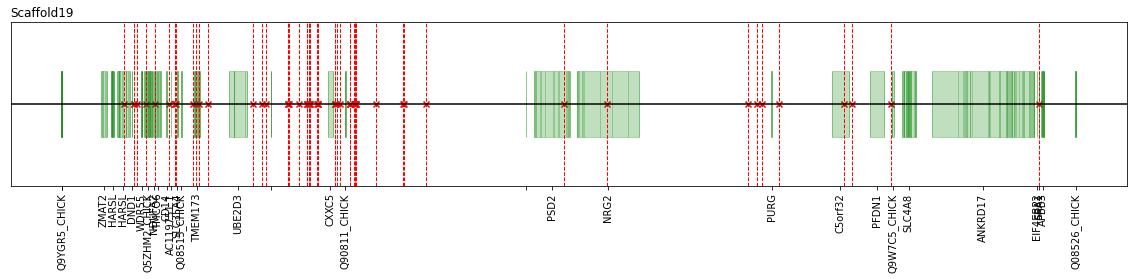

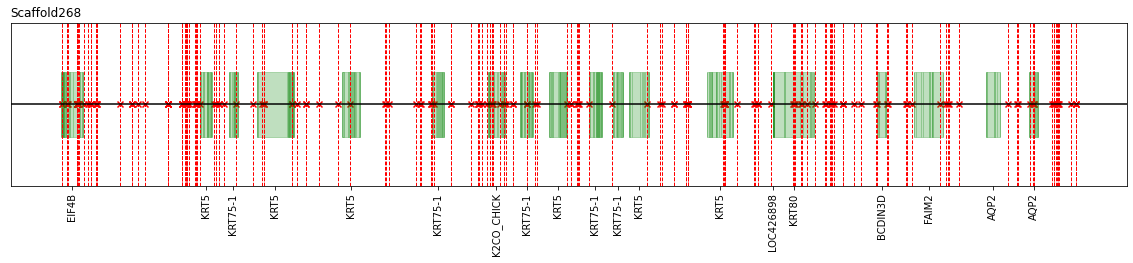

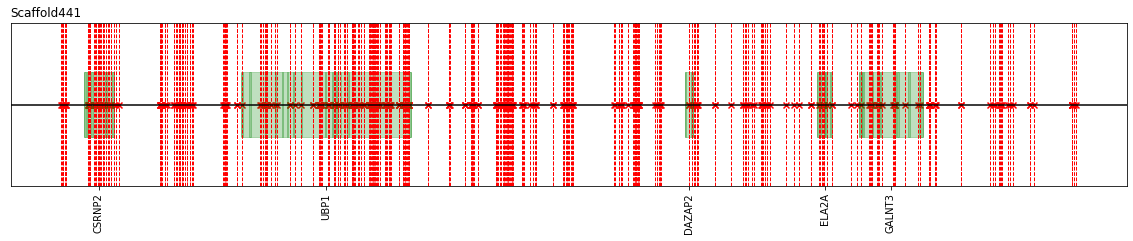

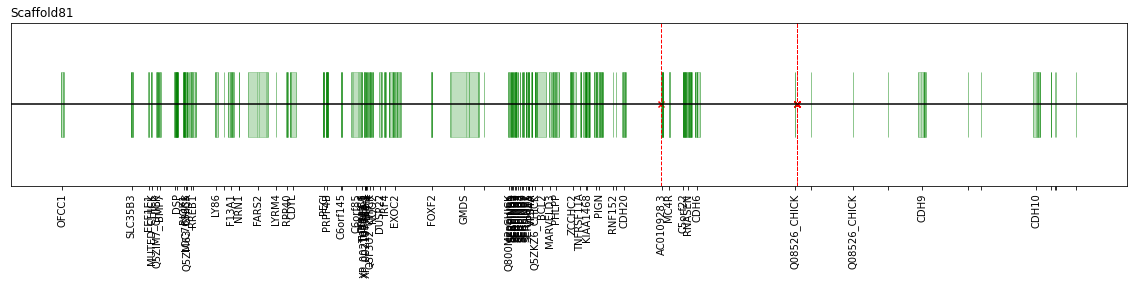

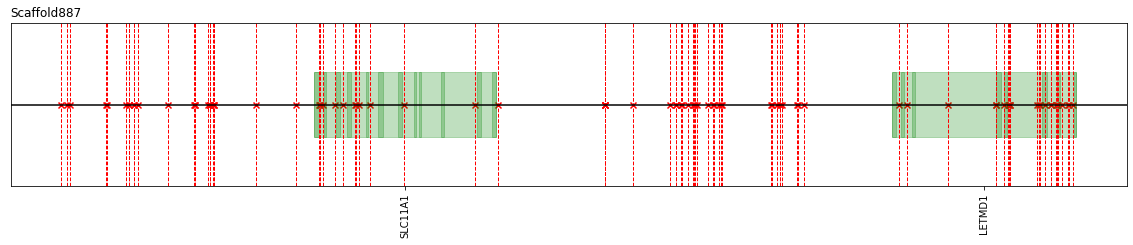

In [295]:
hits_pcadapt = pd.read_csv("/scratch/project_2000913/Penguins/Macaroni/dapc/pcadapt.res", delimiter=" ")
hits_pcadapt.rename(columns={'V2': 'CHROM', 'V4': 'POS'}, inplace=True)

# Keep only scaffolds with more than 5 hits:
c = dict(Counter(hits_pcadapt["CHROM"]))
pcadapt_res = [x for x in c if c[x]>5]
print(pcadapt_res)

for h in pcadapt_res:
    plotRegion(hits_pcadapt, h)

In [382]:
scafDict["Scaffold268"]

381695

In [296]:
# Find which feature a SNP may belong to:
def snp_in_feature(chrom, pos, gff):
    # gff is a pandas dataframe as formatted in this notebook
    this_gff = gff.loc[gff["scaffold"] == chrom].copy()
    this_gff.reset_index(inplace=True, drop=True)
    for i in range(this_gff.shape[0]):
        g = this_gff.loc[i]
        if int(g["start"]) <= int(pos) and int(g["end"]) >= int(pos):
            return([chrom, pos, g["feature"], g["start"], g["end"], g["attributes"]])

In [297]:
df = pd.DataFrame(columns=('scaffold', 'source', "feature", "start", "end", "score", "strand", "phase", "attributes"))
with gzip.open("/scratch/project_2000913/Penguins/Emperor/ref/Aptenodytes_forsteri.gff.gz", "rt") as ifile:
    i = 0
    for line in ifile:
        row = line.strip("\n").split("\t")
        gffScaf = row[0]
        gffFeat = row[2]
        if gffScaf in pcadapt_res:
            df.loc[i] = row
            i += 1

In [298]:
genes = pd.DataFrame(columns=('scaffold', 'pos', "feature", "start", "end", "attributes"))

k = 0
for i in range(hits_pcadapt.shape[0]):
    c = hits_pcadapt["CHROM"].loc[i]
    p = int(hits_pcadapt["POS"].loc[i])
    res = snp_in_feature(c, p, df)
    if res:
        genes.loc[k] = res
        k += 1

In [299]:
[x for x in set([f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in genes["attributes"]]]) if x]

['AQP2',
 'DAZAP2',
 'SLC11A1',
 'MARS',
 'KRT75-1',
 'LETMD1',
 'DDIT3',
 'UBP1',
 'HARSL',
 'TMCO6',
 'EIF4B',
 'KRT80',
 'K2CO_CHICK',
 'NRG2',
 'KRT5',
 'GALNT3',
 'C5orf32',
 'TMEM173',
 'Q5ZHM2_CHICK',
 'CSRNP2',
 'PSD2',
 'FAIM2',
 'ELA2A']

On Panther Pathways cellular component analysis, there is a >100 fold enrichment for Keratin related genes, unsurprisingly.

In [272]:
ID = [f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "ID" in x] for y in genes["attributes"]]]
FN = [f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in genes["attributes"]]]
S = [x for x in genes["scaffold"]]
FEAT = [x for x in genes["feature"]]
c = Counter([FN[i] + "-" + S[i] + "-" + FEAT[i] + "-" + x for i, x in enumerate(ID)])
[(x, c[x]) for x in sorted(c)[1:]]

[('AQP2-Scaffold268-mRNA-Afo_R007413', 4),
 ('C5orf32-Scaffold19-mRNA-Afo_R004368', 1),
 ('CSRNP2-Scaffold441-mRNA-Afo_R010615', 27),
 ('DAZAP2-Scaffold441-mRNA-Afo_R010617', 4),
 ('DDIT3-Scaffold133-mRNA-Afo_R001543', 5),
 ('EIF4B-Scaffold268-mRNA-Afo_R007395', 15),
 ('ELA2A-Scaffold441-mRNA-Afo_R010618', 11),
 ('FAIM2-Scaffold268-mRNA-Afo_R007411', 1),
 ('GALNT3-Scaffold441-mRNA-Afo_R010619', 19),
 ('HARSL-Scaffold19-mRNA-Afo_R004349', 1),
 ('K2CO_CHICK-Scaffold268-mRNA-Afo_R007401', 7),
 ('KRT5-Scaffold268-mRNA-Afo_R007398', 5),
 ('KRT5-Scaffold268-mRNA-Afo_R007399', 1),
 ('KRT5-Scaffold268-mRNA-Afo_R007406', 1),
 ('KRT5-Scaffold268-mRNA-Afo_R007407', 6),
 ('KRT75-1-Scaffold268-mRNA-Afo_R007397', 1),
 ('KRT75-1-Scaffold268-mRNA-Afo_R007400', 2),
 ('KRT75-1-Scaffold268-mRNA-Afo_R007402', 2),
 ('KRT80-Scaffold268-mRNA-Afo_R007409', 6),
 ('LETMD1-Scaffold887-mRNA-Afo_R015412', 23),
 ('MARS-Scaffold133-mRNA-Afo_R001544', 24),
 ('NRG2-Scaffold19-mRNA-Afo_R004366', 1),
 ('PSD2-Scaffold19-

In [279]:
Counter([f[0] for f in [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in genes["attributes"]]])

Counter({'DDIT3': 5,
         'MARS': 24,
         '': 3,
         'HARSL': 1,
         'Q5ZHM2_CHICK': 1,
         'TMCO6': 1,
         'TMEM173': 2,
         'PSD2': 1,
         'NRG2': 1,
         'C5orf32': 1,
         'EIF4B': 15,
         'KRT75-1': 5,
         'KRT5': 13,
         'K2CO_CHICK': 7,
         'KRT80': 6,
         'FAIM2': 1,
         'AQP2': 4,
         'CSRNP2': 27,
         'UBP1': 121,
         'DAZAP2': 4,
         'ELA2A': 11,
         'GALNT3': 19,
         'SLC11A1': 12,
         'LETMD1': 23})

In [293]:
# All genes in the retained scaffolds:
pcadapt_res
df_res = df.loc[df["scaffold"].isin(pcadapt_res)]
j = [[x.split("=")[1].strip('""') for x in y.split(";") if "Function" in x] for y in df_res["attributes"]]
k = [f[0] for f in j if f]
sorted([x for x in set(k) if x])

['AC119751.1',
 'ANKRD17',
 'APBB3',
 'AQP2',
 'BCDIN3D',
 'C5orf32',
 'CD14',
 'CSRNP2',
 'CXXC5',
 'DAZAP2',
 'DDIT3',
 'DND1',
 'EIF4B',
 'EIF4EBP2',
 'ELA2A',
 'FAIM2',
 'GALNT3',
 'HARSL',
 'K2CO_CHICK',
 'KRT5',
 'KRT75-1',
 'KRT80',
 'LETMD1',
 'LOC426898',
 'MARS',
 'NDUFA2',
 'NRG2',
 'PFDN1',
 'PSD2',
 'PURG',
 'Q08515_CHICK',
 'Q08526_CHICK',
 'Q5ZHM2_CHICK',
 'Q90811_CHICK',
 'Q9W7C5_CHICK',
 'Q9YGR5_CHICK',
 'SLC11A1',
 'SLC35A4',
 'SLC4A8',
 'SRA1',
 'TMCO6',
 'TMEM173',
 'UBE2D3',
 'UBP1',
 'WDR55',
 'ZMAT2']

In [280]:
# Plot Scaffold19 with genes on it, and DAPC positions:
plt.rcParams['figure.figsize'] = [20, 3]

geneloc, genename = [], []

# Overall span of the genes:
for i in range(mRNAdf.shape[0]):
    s = int(mRNAdf["start"][i])
    e = int(mRNAdf["end"][i])
    geneloc.append(np.mean([s, e]))
    genename.append(mRNAdf["function"][i])
    plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")
    
# CDS:
for i in range(CDSdf.shape[0]):
    s = int(CDSdf["start"][i])
    e = int(CDSdf["end"][i])
    plt.axvspan(s, e, ymin=.3, ymax=.7, alpha=.25, color="g")

for i in range(scaf19_pcadapt.shape[0]):
    plt.plot([scaf19_pcadapt["POS"][i], scaf19_pcadapt["POS"][i]], [0, 1], c="r", lw=1, ls="--")
    plt.scatter(scaf19_pcadapt["POS"][i], 0, c="r", marker="x")
    
for i in range(scaf19_dapc.shape[0]):
    plt.plot([scaf19_dapc["POS"][i], scaf19_dapc["POS"][i]], [-1, 0], c="b", lw=1, ls="--")
    plt.scatter(scaf19_dapc["POS"][i], 0, c="b", marker="x")

    
plt.ylim(-1, 1)
minx, maxx = plt.xlim()
plt.axhline(0, c='k')
plt.yticks([])
plt.xticks(geneloc, genename, rotation=90)
plt.show()

KeyError: 'function'

There is a good agreement between DAPC and PCAdapt on Scaffold19 as a target region for differentiation - possibly a short-range synteny issue? The agreement is not too surprising, though, considering the two approaches are virtually the same, but in an LDA vs. PCA framework.

However we need to make sure the same region does not also come up when we remove _Eudyptes schlegeli_ altogether.


Note: CXXC5 -> hypoxia https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6349197/ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3575822/ + hair https://yonsei.pure.elsevier.com/en/publications/targeting-of-cxxc5-by-a-competing-peptide-stimulates-hair-regrowt

### Look at nucleotide diversity across the genome:

In [368]:
%%bash
module load vcftools
vcftools --gzvcf /users/cristofa/scratch/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf \
--out /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eudyptes_filteredSNPs \
--window-pi 1000

vcftools  0.1.16  environment loaded 

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /users/cristofa/scratch/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf
	--out /users/cristofa/scratch/Penguins/Macaroni/vcfstats/eudyptes_filteredSNPs
	--window-pi 1000

Using zlib version: 1.2.7
After filtering, kept 48 out of 48 Individuals
Outputting Windowed Nucleotide Diversity Statistics...
After filtering, kept 883354 out of a possible 883354 Sites
Run Time = 8.00 seconds


In [369]:
pi = pd.read_csv("/scratch/project_2000913/Penguins/Macaroni/vcfstats/eudyptes_filteredSNPs.windowed.pi", delimiter="\t")
pi["POS"] = [(pi["BIN_START"][i]+pi["BIN_END"][i])/2 for i in range(pi.shape[0])]

In [370]:
# Sort the dataframe by scaffold length:
pi["LEN"] = [scafDict[s] for s in pi["CHROM"]]
pi = pi.sort_values(['LEN', 'CHROM', 'POS'], ascending=(False, True, True))
pi.reset_index(inplace=True, drop=True)

# Add a FULLPOS column corresponding to position + cumulative sum of sorted scaffold lengths
uniquePairs = [x for x in sorted(set([x for x in zip(pi["CHROM"], pi["LEN"])]), key = lambda t: t[1], reverse = True)]
s = [x[0] for x in uniquePairs]
l = [x[1] for x in uniquePairs]
l = [0] + l[:-1]
csDict=dict(zip(s, np.cumsum(l)))

pi["FULLPOS"] = [csDict[x] + pi["POS"][i] for i, x in enumerate(pi["CHROM"])]

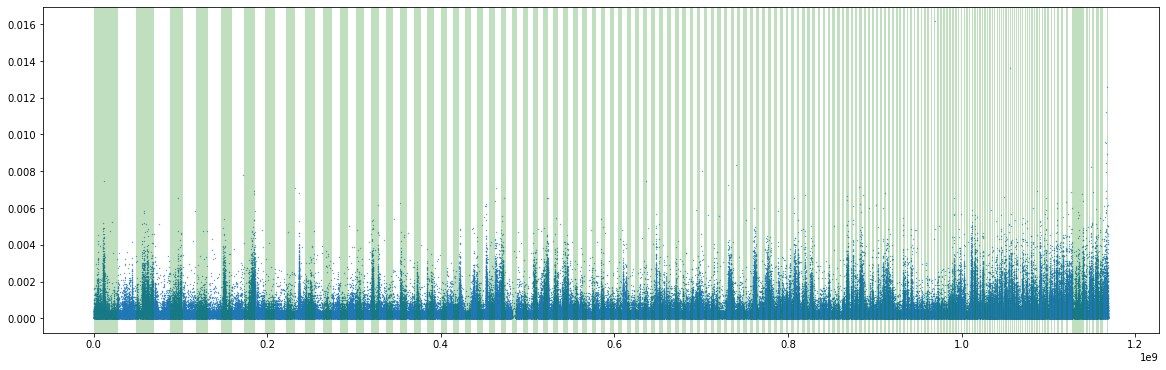

In [371]:
plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(pi["FULLPOS"], pi["PI"], s=.1)
plt.show()

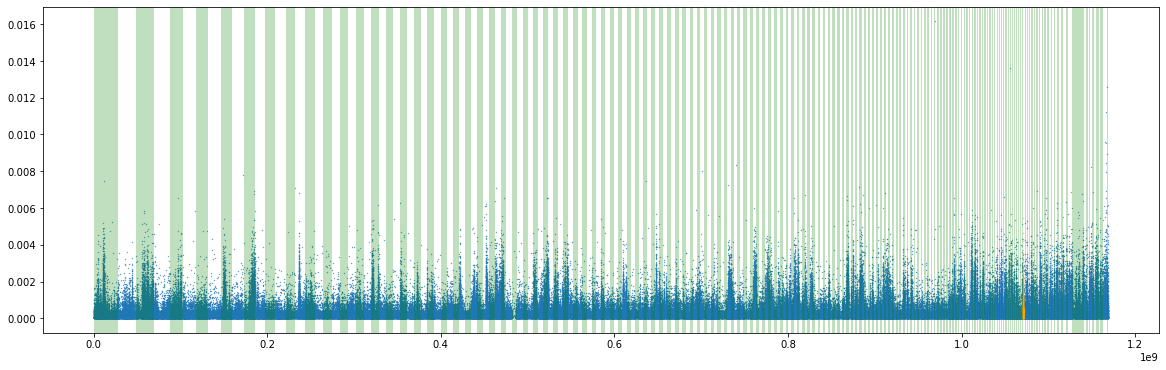

In [378]:
# With Scaffold19 etc outlined:
pi_outline = pi.loc[pi["CHROM"].isin(["Scaffold19"])]
pi_bulk = pi.loc[-pi["CHROM"].isin(["Scaffold19"])]

plt.rcParams['figure.figsize'] = [20, 6]
for b in bandsPOS:
    plt.axvspan(b[0], b[1], facecolor='g', alpha=0.25)
plt.scatter(pi_bulk["FULLPOS"], pi_bulk["PI"], s=.1)
plt.scatter(pi_outline["FULLPOS"], pi_outline["PI"], s=.1, c='orange')
plt.show()